In [684]:
import pandas as pd
import numpy as np

In [694]:
train_dataset = pd.read_csv("train.csv")
test_dataset = pd.read_csv("test.csv")
train_lim = len(train_dataset)
dataset = train_dataset.append(test_dataset)

In [695]:
dataset.head(10)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450
5,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909
8,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742
9,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736


In [696]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


**Cabin**, **Age** and **Embarked** attributes are sometimes misssing, since their count is less than 891

In [697]:
dataset["Sex"].value_counts()

male      843
female    466
Name: Sex, dtype: int64

In [698]:
dataset["Embarked"].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [699]:
dataset["Pclass"].value_counts()

3    709
1    323
2    277
Name: Pclass, dtype: int64

In [700]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


## Creating Pipelines

First, the numerical pipeline

In [701]:
from sklearn.base import TransformerMixin, BaseEstimator

class DataFrameSelector(TransformerMixin, BaseEstimator):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [702]:
class RelativesOnBoardAdder(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X["RelativesOnBoard"] = X["SibSp"] + X["Parch"]
        return X

In [703]:
class AgeBucketAdder(TransformerMixin, BaseEstimator):
    def __init__(self, bucket_size):
        self.bucket_size = bucket_size
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X["AgeBucket"] = X["Age"] // self.bucket_size
        return X

In [704]:
import re
class TitleAdder(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X["Title"] = X.Name.apply(lambda x : x.split(',')[1].split('.')[0][1:])
        X["Title"] = X["Title"].replace({'Ms':'Miss', 'Mlle':'Miss', 'Mme':'Mrs'})
        X["Title"] = X["Title"].replace(['Dr', 'Rev', 'Major', 'Col', 'Lady', 'the Countess', 'Jonkheer', 'Capt', 'Don', 'Sir'], 'Rare')
        return X

In [705]:
from sklearn.preprocessing import Imputer

class CustomImputer(TransformerMixin, BaseEstimator):
    def __init__(self, strategy):
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        imp = Imputer(strategy=self.strategy)
        X_imputed = pd.DataFrame(imp.fit_transform(X))
        X_imputed.columns = X.columns
        X_imputed.index = X.index
        return X_imputed

In [706]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ('numerical_selector', DataFrameSelector(["SibSp", "Parch", "Fare"])),
    ('imputer', CustomImputer('median')),
    ('relatives_on_board_adder', RelativesOnBoardAdder()),
    ('final_numerical_selector', DataFrameSelector(["RelativesOnBoard", "Fare"]))
])

In [707]:
num_pipeline.fit_transform(dataset)

,RelativesOnBoard,Fare
0,1.0,7.2500
1,1.0,71.2833
2,0.0,7.9250
3,1.0,53.1000
4,0.0,8.0500
5,0.0,8.4583
6,0.0,51.8625
7,4.0,21.0750
8,2.0,11.1333
9,1.0,30.0708


Then, then the categorical variable

In [708]:
# @hidden cell
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, no need to try to
# understand every line.

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [709]:
class MostFrequentImputer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        self.most_frequent = pd.Series([X[c].value_counts().index[0] for c in X], index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent)

In [710]:
cat_pipeline = Pipeline([
    ('title_adder', TitleAdder()),
    ('age_bucket_adder', AgeBucketAdder(15)),
    ('cat_selector', DataFrameSelector(["AgeBucket","Pclass", "Sex", "Embarked", "Title"])),
    ('cat_imputer', MostFrequentImputer()),
    ('cat_encoder', CategoricalEncoder(encoding='onehot-dense'))
])

In [711]:
cat_pipeline.fit_transform(dataset).shape

(1309, 20)

In [712]:
#Note that the feature union launchs the pipelins in parallel, and then concatenate the results
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion([
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

In [720]:
def seperate_train_test(dataset, train_lim):
    X = preprocess_pipeline.fit_transform(dataset)
    return X[:train_lim], dataset["Survived"].head(train_lim), X[train_lim:]

In [721]:
X_train, y_train, X_test = seperate_train_test(dataset, train_lim)

In [717]:
X_train.shape

(891, 22)

In [718]:
y_train.shape

(891,)

In [722]:
X_test.shape

(418, 22)

In [723]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [724]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(svm_clf, X_train, y_train, cv=3)

In [725]:
score.mean()

0.77665544332211

In [726]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
score = cross_val_score(forest_clf, X_train, y_train, cv=3)
score.mean()

0.8159371492704827

In [727]:
from sklearn.model_selection import GridSearchCV

grid_param = {
    'n_estimators' : [3, 4, 5, 6, 7, 8, 9, 10],
    'criterion' : ['gini', 'entropy'],
    'max_features' : ['sqrt', 'log2']
}

grid_search = GridSearchCV(RandomForestClassifier(), grid_param, scoring='accuracy', cv=10,verbose=3)

In [728]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 32 candidates, totalling 320 fits
[CV] criterion=gini, max_features=sqrt, n_estimators=3 ...............
[CV]  criterion=gini, max_features=sqrt, n_estimators=3, score=0.7444444444444445, total=   0.0s
[CV] criterion=gini, max_features=sqrt, n_estimators=3 ...............
[CV]  criterion=gini, max_features=sqrt, n_estimators=3, score=0.7777777777777778, total=   0.0s
[CV] criterion=gini, max_features=sqrt, n_estimators=3 ...............
[CV]  criterion=gini, max_features=sqrt, n_estimators=3, score=0.7303370786516854, total=   0.0s
[CV] criterion=gini, max_features=sqrt, n_estimators=3 ...............
[CV]  criterion=gini, max_features=sqrt, n_estimators=3, score=0.8089887640449438, total=   0.0s
[CV] criterion=gini, max_features=sqrt, n_estimators=3 ...............
[CV]  criterion=gini, max_features=sqrt, n_estimators=3, score=0.8089887640449438, total=   0.0s
[CV] criterion=gini, max_features=sqrt, n_estimators=3 ...............
[CV]  criterion=gini, max_

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=gini, max_features=sqrt, n_estimators=4, score=0.7415730337078652, total=   0.0s
[CV] criterion=gini, max_features=sqrt, n_estimators=4 ...............
[CV]  criterion=gini, max_features=sqrt, n_estimators=4, score=0.797752808988764, total=   0.0s
[CV] criterion=gini, max_features=sqrt, n_estimators=4 ...............
[CV]  criterion=gini, max_features=sqrt, n_estimators=4, score=0.8089887640449438, total=   0.0s
[CV] criterion=gini, max_features=sqrt, n_estimators=4 ...............
[CV]  criterion=gini, max_features=sqrt, n_estimators=4, score=0.797752808988764, total=   0.0s
[CV] criterion=gini, max_features=sqrt, n_estimators=4 ...............
[CV]  criterion=gini, max_features=sqrt, n_estimators=4, score=0.8089887640449438, total=   0.0s
[CV] criterion=gini, max_features=sqrt, n_estimators=4 ...............
[CV]  criterion=gini, max_features=sqrt, n_estimators=4, score=0.7752808988764045, total=   0.0s
[CV] criterion=gini, max_features=sqrt, n_estimators=4 ..........

[CV]  criterion=gini, max_features=sqrt, n_estimators=9, score=0.7640449438202247, total=   0.0s
[CV] criterion=gini, max_features=sqrt, n_estimators=9 ...............
[CV]  criterion=gini, max_features=sqrt, n_estimators=9, score=0.8202247191011236, total=   0.0s
[CV] criterion=gini, max_features=sqrt, n_estimators=9 ...............
[CV]  criterion=gini, max_features=sqrt, n_estimators=9, score=0.8295454545454546, total=   0.0s
[CV] criterion=gini, max_features=sqrt, n_estimators=10 ..............
[CV]  criterion=gini, max_features=sqrt, n_estimators=10, score=0.7555555555555555, total=   0.0s
[CV] criterion=gini, max_features=sqrt, n_estimators=10 ..............
[CV]  criterion=gini, max_features=sqrt, n_estimators=10, score=0.8222222222222222, total=   0.0s
[CV] criterion=gini, max_features=sqrt, n_estimators=10 ..............
[CV]  criterion=gini, max_features=sqrt, n_estimators=10, score=0.7528089887640449, total=   0.0s
[CV] criterion=gini, max_features=sqrt, n_estimators=10 ....

[CV]  criterion=gini, max_features=log2, n_estimators=6, score=0.8295454545454546, total=   0.0s
[CV] criterion=gini, max_features=log2, n_estimators=7 ...............
[CV]  criterion=gini, max_features=log2, n_estimators=7, score=0.7444444444444445, total=   0.0s
[CV] criterion=gini, max_features=log2, n_estimators=7 ...............
[CV]  criterion=gini, max_features=log2, n_estimators=7, score=0.8444444444444444, total=   0.0s
[CV] criterion=gini, max_features=log2, n_estimators=7 ...............
[CV]  criterion=gini, max_features=log2, n_estimators=7, score=0.7528089887640449, total=   0.0s
[CV] criterion=gini, max_features=log2, n_estimators=7 ...............
[CV]  criterion=gini, max_features=log2, n_estimators=7, score=0.8426966292134831, total=   0.0s
[CV] criterion=gini, max_features=log2, n_estimators=7 ...............
[CV]  criterion=gini, max_features=log2, n_estimators=7, score=0.8089887640449438, total=   0.0s
[CV] criterion=gini, max_features=log2, n_estimators=7 ........

[CV]  criterion=entropy, max_features=sqrt, n_estimators=4, score=0.8089887640449438, total=   0.0s
[CV] criterion=entropy, max_features=sqrt, n_estimators=4 ............
[CV]  criterion=entropy, max_features=sqrt, n_estimators=4, score=0.8426966292134831, total=   0.0s
[CV] criterion=entropy, max_features=sqrt, n_estimators=4 ............
[CV]  criterion=entropy, max_features=sqrt, n_estimators=4, score=0.8314606741573034, total=   0.0s
[CV] criterion=entropy, max_features=sqrt, n_estimators=4 ............
[CV]  criterion=entropy, max_features=sqrt, n_estimators=4, score=0.8181818181818182, total=   0.0s
[CV] criterion=entropy, max_features=sqrt, n_estimators=5 ............
[CV]  criterion=entropy, max_features=sqrt, n_estimators=5, score=0.7444444444444445, total=   0.0s
[CV] criterion=entropy, max_features=sqrt, n_estimators=5 ............
[CV]  criterion=entropy, max_features=sqrt, n_estimators=5, score=0.8111111111111111, total=   0.0s
[CV] criterion=entropy, max_features=sqrt, n_

[CV]  criterion=entropy, max_features=sqrt, n_estimators=9, score=0.8539325842696629, total=   0.0s
[CV] criterion=entropy, max_features=sqrt, n_estimators=9 ............
[CV]  criterion=entropy, max_features=sqrt, n_estimators=9, score=0.8089887640449438, total=   0.0s
[CV] criterion=entropy, max_features=sqrt, n_estimators=9 ............
[CV]  criterion=entropy, max_features=sqrt, n_estimators=9, score=0.7528089887640449, total=   0.0s
[CV] criterion=entropy, max_features=sqrt, n_estimators=9 ............
[CV]  criterion=entropy, max_features=sqrt, n_estimators=9, score=0.797752808988764, total=   0.0s
[CV] criterion=entropy, max_features=sqrt, n_estimators=9 ............
[CV]  criterion=entropy, max_features=sqrt, n_estimators=9, score=0.8522727272727273, total=   0.0s
[CV] criterion=entropy, max_features=sqrt, n_estimators=10 ...........
[CV]  criterion=entropy, max_features=sqrt, n_estimators=10, score=0.7777777777777778, total=   0.0s
[CV] criterion=entropy, max_features=sqrt, n_

[CV]  criterion=entropy, max_features=log2, n_estimators=6, score=0.797752808988764, total=   0.0s
[CV] criterion=entropy, max_features=log2, n_estimators=6 ............
[CV]  criterion=entropy, max_features=log2, n_estimators=6, score=0.8314606741573034, total=   0.0s
[CV] criterion=entropy, max_features=log2, n_estimators=6 ............
[CV]  criterion=entropy, max_features=log2, n_estimators=6, score=0.8522727272727273, total=   0.0s
[CV] criterion=entropy, max_features=log2, n_estimators=7 ............
[CV]  criterion=entropy, max_features=log2, n_estimators=7, score=0.7666666666666667, total=   0.0s
[CV] criterion=entropy, max_features=log2, n_estimators=7 ............
[CV]  criterion=entropy, max_features=log2, n_estimators=7, score=0.8111111111111111, total=   0.0s
[CV] criterion=entropy, max_features=log2, n_estimators=7 ............
[CV]  criterion=entropy, max_features=log2, n_estimators=7, score=0.7640449438202247, total=   0.0s
[CV] criterion=entropy, max_features=log2, n_e

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    7.4s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [3, 4, 5, 6, 7, 8, 9, 10], 'criterion': ['gini', 'entropy'], 'max_features': ['sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=3)

In [729]:
grid_search.best_params_

{'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 10}

In [730]:
grid_search.best_score_

0.8237934904601572

In [737]:
def submit(classifier, test_set, file_name='submission.csv'):
    y_pred = classifier.predict(preprocess_pipeline.fit_transform(test_set)).astype(int)
    d = {'PassengerId' : [892 + i for i in range(0, len(test_set))], 'Survived' : y_pred}
    submission = pd.DataFrame(data=d)
    submission.to_csv(file_name, index=False)

In [738]:
submit(grid_search.best_estimator_, test_dataset, "random_forest.csv")

## Reaching Better Score

First using Adaboost

In [739]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_clf = AdaBoostClassifier()
cross_val_score(adaboost_clf, X_train, y_train, cv=5).mean()

0.821578580226095

In [740]:
param_grid = {
    'n_estimators':[100, 150, 200],
    'learning_rate':[0.3, 0.4]
}

grid_search_adaboost = GridSearchCV(AdaBoostClassifier(), param_grid, cv=10, scoring='accuracy', verbose=3)

In [741]:
grid_search_adaboost.fit(X_train, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] learning_rate=0.3, n_estimators=100 .............................
[CV]  learning_rate=0.3, n_estimators=100, score=0.8111111111111111, total=   0.1s
[CV] learning_rate=0.3, n_estimators=100 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV]  learning_rate=0.3, n_estimators=100, score=0.8222222222222222, total=   0.1s
[CV] learning_rate=0.3, n_estimators=100 .............................
[CV]  learning_rate=0.3, n_estimators=100, score=0.7865168539325843, total=   0.1s
[CV] learning_rate=0.3, n_estimators=100 .............................
[CV]  learning_rate=0.3, n_estimators=100, score=0.8651685393258427, total=   0.1s
[CV] learning_rate=0.3, n_estimators=100 .............................
[CV]  learning_rate=0.3, n_estimators=100, score=0.8314606741573034, total=   0.1s
[CV] learning_rate=0.3, n_estimators=100 .............................
[CV]  learning_rate=0.3, n_estimators=100, score=0.8089887640449438, total=   0.1s
[CV] learning_rate=0.3, n_estimators=100 .............................
[CV]  learning_rate=0.3, n_estimators=100, score=0.8426966292134831, total=   0.1s
[CV] learning_rate=0.3, n_estimators=100 .............................
[CV]  learning_rate=0.3, n_estimators=100, score=0.8089887640449438, total= 

[CV]  learning_rate=0.4, n_estimators=200, score=0.8089887640449438, total=   0.2s
[CV] learning_rate=0.4, n_estimators=200 .............................
[CV]  learning_rate=0.4, n_estimators=200, score=0.8426966292134831, total=   0.2s
[CV] learning_rate=0.4, n_estimators=200 .............................
[CV]  learning_rate=0.4, n_estimators=200, score=0.7865168539325843, total=   0.2s
[CV] learning_rate=0.4, n_estimators=200 .............................
[CV]  learning_rate=0.4, n_estimators=200, score=0.8539325842696629, total=   0.2s
[CV] learning_rate=0.4, n_estimators=200 .............................
[CV]  learning_rate=0.4, n_estimators=200, score=0.8522727272727273, total=   0.2s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   16.6s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 150, 200], 'learning_rate': [0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=3)

In [742]:
grid_search_adaboost.best_score_

0.8282828282828283

In [889]:
grid_search_adaboost.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.3, n_estimators=150, random_state=None)

Still lower than the Random Forest Classifier

In [744]:
submit(grid_search_adaboost, test_dataset, 'New-adaboost.csv') ##Scored 0.75598 , impouvement

Using xgboost

In [745]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.3.0-posix-seh-rt_v5-rev0'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [746]:
import xgboost as xgb

In [747]:
xgb_clf = xgb.XGBClassifier()
cross_val_score(xgb_clf, X_train, y_train, cv=10, scoring='accuracy', verbose=3).mean()

[CV]  ................................................................
[CV] ....................... , score=0.7888888888888889, total=   0.0s
[CV]  ................................................................
[CV] ....................... , score=0.8222222222222222, total=   0.0s
[CV]  ................................................................
[CV] ....................... , score=0.7640449438202247, total=   0.0s
[CV]  ................................................................


c:\users\bennej~1\docume~1\ml\env\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
c:\users\bennej~1\docume~1\ml\env\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
c:\users\bennej~1\docume~1\ml\env\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not 

[CV] ....................... , score=0.8764044943820225, total=   0.0s
[CV]  ................................................................
[CV] ....................... , score=0.8651685393258427, total=   0.0s
[CV]  ................................................................
[CV] ....................... , score=0.8426966292134831, total=   0.0s
[CV]  ................................................................
[CV] ....................... , score=0.8539325842696629, total=   0.0s
[CV]  ................................................................


c:\users\bennej~1\docume~1\ml\env\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\bennej~1\docume~1\ml\env\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\bennej~1\docume~1\ml\env\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\bennej~1\docume~1\ml\env\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array 

[CV] ....................... , score=0.7865168539325843, total=   0.0s
[CV]  ................................................................
[CV] ........................ , score=0.898876404494382, total=   0.0s
[CV]  ................................................................
[CV] ....................... , score=0.8295454545454546, total=   0.0s


c:\users\bennej~1\docume~1\ml\env\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\bennej~1\docume~1\ml\env\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished


0.8328297015094769

Already better score, now let's try tuning the params

In [748]:
X_train_xgb = xgb.DMatrix(X_train)

In [749]:
dataset.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,AgeBucket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr,1.0
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs,2.0
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss,1.0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs,2.0
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr,2.0


In [750]:
X_train.shape

(891, 22)

In [751]:
X_train[0]

array([1.  , 7.25, 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ,
       0.  , 1.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ])

In [752]:
label = ["AgeBucket", "RelativesOnBoard","Fare", "Pclass0", "Pclass1","Pclass2", "Sex0","Sex1", "Embarked0", "Embarked1", "Embarked2", "Title0", "Title1", "Title2", "Title3", "Title4", "Title5", "Title6"]

In [753]:
def get_score_with_f_name(xgb_model):
    return dict((label[eval(key[1])], value) for (key, value) in xgb_model.get_booster().get_score().items())

In [754]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

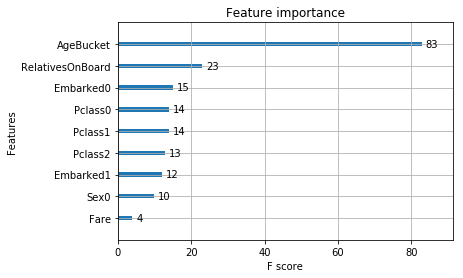

In [784]:
xgb_clf.fit(X_train, y_train)
xgb.plot_importance(get_score_with_f_name(xgb_clf))

In [785]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [901]:
def model_fit(alg, X, y, useTrainCV=True, cv_folds=5, early_stopping_rounds=100):
    if useTrainCV:
        xgb_params = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X, label=y)
        cvresult = xgb.cv(xgb_params, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        #To get the number of the trees
        alg.set_params(n_estimators=cvresult.shape[0])
        
        #Fitting the algorithm on the data
        alg.fit(X, y,eval_metric='auc')
        
        #Predict the dataset
        
        y_pred = alg.predict(X)
        y_pred_proba = alg.predict_proba(X)[:,1]
        
        #Plotting results
        
        print("Model Report")
        print("Accuracy : %.4g" % accuracy_score(y, y_pred))
        print("AUC Score : %f" % roc_auc_score(y, y_pred_proba))
        
        xgb.plot_importance(get_score_with_f_name(alg))

model_fit(xgb_clf, X_train, y_train)

c:\users\bennej~1\docume~1\ml\env\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Model Report
Accuracy : 0.8709
AUC Score : 0.925116


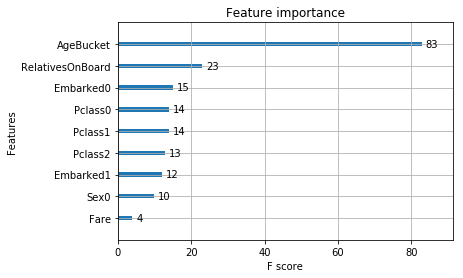

In [900]:
model_fit(xgb_clf, X_train, y_train)

Tuning a model works as follows:
<ol>
<li>Start by picking a high **learning rate** value, say 0.1.</li>
<li>Tune **tree-specific parameters** (max_depth, min_child_weight, gamma, subsample, colsample_bytree).</li>
<li>Tune **Regularization parameters** (lamda, alpha) to reduce model complexity hence, increase its performance.</li>
<li>**Lowering the learning rate**.</li>
</ol>

We start by picking some default values:

In [788]:
xgb1 = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=42
)

Model Report
Accuracy : 0.908
AUC Score : 0.958654


c:\users\bennej~1\docume~1\ml\env\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


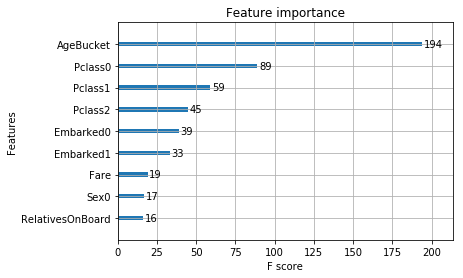

In [789]:
model_fit(xgb1, X_train, y_train)

Tuning **max_depth** and **min_child_weight**

In [790]:
param_test1 = {
    'max_depth' : range(3, 10, 2),
    'min_child_weight' : range(1,6,2)
}

gsearch1 = GridSearchCV(estimator=xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    scale_pos_weight=1,
    seed=42), param_grid=param_test1, scoring='roc_auc',n_jobs=-1, cv=5, verbose=3)

gsearch1.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   27.2s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=3)

In [791]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 5}, 0.879601224316023)

In [842]:
param_test2 = {
    'max_depth' : [1, 2, 7, 8, 9, 10, 15],
    'min_child_weight' : [1, 2, 3, 8]
}

gsearch2 = GridSearchCV(estimator=xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    scale_pos_weight=1,
    seed=42), param_grid=param_test2, scoring='roc_auc',n_jobs=-1, cv=5, verbose=3)

gsearch2.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  1.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [1, 2, 7, 8, 9, 10, 15], 'min_child_weight': [1, 2, 3, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=3)

In [850]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 2, 'min_child_weight': 8}, 0.883984543728295)

c:\users\bennej~1\docume~1\ml\env\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Model Report
Accuracy : 0.8923
AUC Score : 0.943824


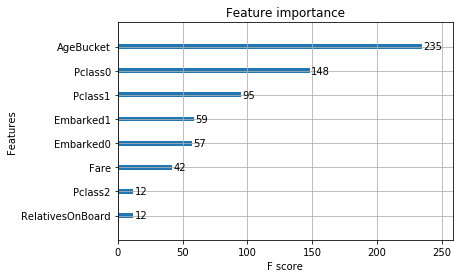

In [841]:
xgb1_5 = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depht=2,
    min_child_weight=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    scale_pos_weight=1,
    gamma=0,
    seed=42)
model_fit(xgb1_5, X_train, y_train)

Tuning **Gamma**

In [851]:
param_test4 = {
    'gamma': [i / 10 for i in range(1, 11)]
}

gsearch4 = GridSearchCV(estimator=xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depht=2,
    min_child_weight=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    scale_pos_weight=1,
    seed=42), param_grid=param_test4, scoring='roc_auc',n_jobs=-1, cv=5, verbose=3)

gsearch4.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   18.0s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depht=2, max_depth=3, min_child_weight=8, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=3)

In [853]:
gsearch4.best_params_, gsearch4.best_score_

({'gamma': 0.2}, 0.8837453783604858)

In [856]:
param_test5 = {
    'gamma': [i / 100 for i in range(10, 30)]
}

gsearch5 = GridSearchCV(estimator=xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depht=2,
    min_child_weight=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    scale_pos_weight=1,
    seed=42), param_grid=param_test5, scoring='roc_auc',n_jobs=-1, cv=5, verbose=3)

gsearch5.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.7s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depht=2, max_depth=3, min_child_weight=8, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'gamma': [0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=3)

In [857]:
gsearch5.best_params_, gsearch5.best_score_

({'gamma': 0.26}, 0.8837998551849264)

Values so far:
<ul>
    <li>max_depth: 2</li>
    <li>min_child_weight: 8</li>
    <li>Gamma: 0.26</li>
<ul>

Tuning subsample and colsample_bytree

In [858]:
param_test6 = {
    'subsample': [i / 10 for i in range(5, 11)],
    'colsample_bytree' : [i / 10 for i in range(5, 11)]
}

gsearch6 = GridSearchCV(estimator=xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depht=2,
    min_child_weight=8,
    gamma=0.26,
    objective= 'binary:logistic',
    scale_pos_weight=1,
    seed=42), param_grid=param_test6, scoring='roc_auc',n_jobs=-1, cv=5, verbose=3)

gsearch6.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   52.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.26, learning_rate=0.1, max_delta_step=0,
       max_depht=2, max_depth=3, min_child_weight=8, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=3)

In [860]:
gsearch6.best_params_, gsearch6.best_score_

({'colsample_bytree': 0.6, 'subsample': 0.7}, 0.8841793727087512)

In [861]:
param_test7 = {
    'subsample': [i / 100 for i in range(60, 81)],
    'colsample_bytree' : [i / 100 for i in range(50, 71)]
}

gsearch7 = GridSearchCV(estimator=xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depht=2,
    min_child_weight=8,
    gamma=0.26,
    objective= 'binary:logistic',
    scale_pos_weight=1,
    seed=42), param_grid=param_test7, scoring='roc_auc',n_jobs=-1, cv=5, verbose=3)

gsearch7.fit(X_train, y_train)

Fitting 5 folds for each of 441 candidates, totalling 2205 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 2205 out of 2205 | elapsed: 10.5min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.26, learning_rate=0.1, max_delta_step=0,
       max_depht=2, max_depth=3, min_child_weight=8, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'subsample': [0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8], 'colsample_bytree': [0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=3)

In [862]:
gsearch7.best_params_, gsearch7.best_score_

({'colsample_bytree': 0.55, 'subsample': 0.63}, 0.8855914782788756)

Testing results so far

Values so far:
<ul>
    <li>max_depth: 2</li>
    <li>min_child_weight: 8</li>
    <li>Gamma: 0.26</li>
    <li>subsample: 0.63</li>
    <li>colsample_bytree: 0.55</li>
<ul>

Model Report
Accuracy : 0.8822
AUC Score : 0.932517


c:\users\bennej~1\docume~1\ml\env\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


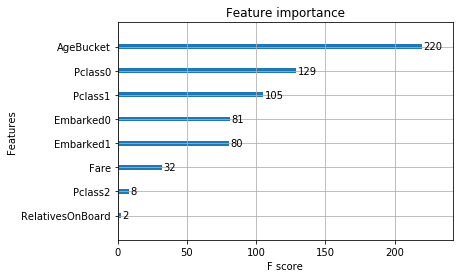

In [863]:
xgb2 = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=2,
    min_child_weight=8,
    gamma=0.26,
    subsample=0.63,
    colsample_bytree=0.55,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=42
)
model_fit(xgb2, X_train, y_train)

Tuning alpha

In [864]:
param_test8 = {
    'reg_alpha': [0, 0.001, 0.005, 0.1, 0.05]
}

gsearch8 = GridSearchCV(estimator=xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=2,
    min_child_weight=8,
    gamma=0.26,
    subsample=0.63,
    colsample_bytree=0.55,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=42
), param_grid=param_test8, scoring='roc_auc',n_jobs=-1, cv=5, verbose=3)

gsearch8.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   17.7s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.55, gamma=0.26, learning_rate=0.1,
       max_delta_step=0, max_depth=2, min_child_weight=8, missing=None,
       n_estimators=1000, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=0.63),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'reg_alpha': [0, 0.001, 0.005, 0.1, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=3)

In [865]:
gsearch8.best_params_, gsearch8.best_score_

({'reg_alpha': 0}, 0.8847087324124705)

Finally, Reducing the learning rate

Model Report
Accuracy : 0.881
AUC Score : 0.937571


c:\users\bennej~1\docume~1\ml\env\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


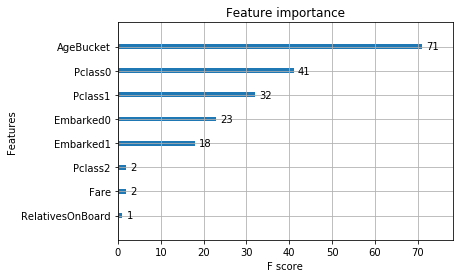

In [882]:
xgb2 = xgb.XGBClassifier(
    learning_rate=0.5,
    n_estimators=5000,
    max_depth=2,
    min_child_weight=8,
    gamma=0.26,
    subsample=0.63,
    colsample_bytree=0.55,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    reg_alpha=0,
    seed=42
)
model_fit(xgb2, X_train, y_train)

c:\users\bennej~1\docume~1\ml\env\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Model Report
Accuracy : 0.8709
AUC Score : 0.925116


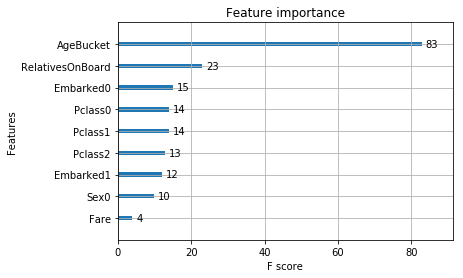

In [883]:
model_fit(xgb_clf, X_train, y_train)

In [884]:
submit(xgb2, test_dataset, 'final_xgb.csv')

c:\users\bennej~1\docume~1\ml\env\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [885]:
submit(xgb_clf,test_dataset, 'xgb_base_line.csv')

c:\users\bennej~1\docume~1\ml\env\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Ensembling

In [887]:
xgb_best = xgb.XGBClassifier(
    learning_rate=0.5,
    n_estimators=5000,
    max_depth=2,
    min_child_weight=8,
    gamma=0.26,
    subsample=0.63,
    colsample_bytree=0.55,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    reg_alpha=0,
    seed=42
)

In [890]:
ada_best = grid_search_adaboost.best_estimator_

In [891]:
rf_best = grid_search.best_estimator_

In [895]:
from sklearn.ensemble import VotingClassifier

votingC = VotingClassifier(estimators=[('xgb', xgb_best), ('ada', ada_best), ('rf', rf_best)], voting='hard', n_jobs=-1)
votingC.fit(X_train, y_train)

VotingClassifier(estimators=[('xgb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.55, gamma=0.26, learning_rate=0.5,
       max_delta_step=0, max_depth=2, min_child_weight=8, missing=None,
       n_estimators=5000, n_jobs=1, nthread=4, objective='binary:logistic',
  ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))],
         flatten_transform=None, n_jobs=-1, voting='hard', weights=None)

In [896]:
submit(votingC, test_dataset, 'first_ensemble.csv')

c:\users\bennej~1\docume~1\ml\env\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\bennej~1\docume~1\ml\env\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
